라이브러리

In [16]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense, Attention, Input
from keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
tank = 1
model_name = 'rereredoRegressor_tank1dofood3'

In [17]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [18]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("eeldata/data/Training/Origin/Management/Japonica/food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("eeldata/data/Training/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")


In [19]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['feed_quantity'].notnull()]
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [20]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[japonica_training_sensor_val_tb['tank_id']==tank]
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[japonica_validation_sensor_val_tb['tank_id']==tank]

#시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_training_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 시계열 데이터의 개수 확인
training_counts = japonica_training_sensor_val_tb.groupby(japonica_training_sensor_val_tb['mea_dt'].dt.date).size()
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = training_counts[training_counts != 1440].index
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[~japonica_training_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)


In [21]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_training_features.set_index('mea_dt', inplace=True)
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_features.sort_index()
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_training_data = japonica_training_data.loc['2021-07-21 00:00':'2021-09-10 23:59']
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

In [22]:
japonica_training_features_X = japonica_training_data[['do_mg','feed_quantity']]

japonica_validation_features_X = japonica_validation_data[['do_mg', 'feed_quantity']]

In [23]:
japonica_training_features_y = japonica_training_features_X[['do_mg']]

japonica_validation_features_y = japonica_validation_features_X[['do_mg']]

In [24]:
japonica_training_features_X_chunks = []
japonica_training_features_y_chunks = []

for i in range(0, len(japonica_training_features_X) - 179):
    japonica_training_features_X_chunks.append(np.array(japonica_training_features_X.iloc[i:i+180].values, dtype=np.float64))
japonica_training_features_X_chunks = np.array(japonica_training_features_X_chunks, dtype=np.float64)

for i in range(0, len(japonica_training_features_y) - 179):
    japonica_training_features_y_chunks.append(np.array(japonica_training_features_y.iloc[i:i+180].values, dtype=np.float64))
japonica_training_features_y_chunks = np.array(japonica_training_features_y_chunks, dtype=np.float64)


In [25]:
japonica_validation_features_X_chunks = []
japonica_validation_features_y_chunks = []


for i in range(0, len(japonica_validation_features_X) - 179):
    japonica_validation_features_X_chunks.append(np.array(japonica_validation_features_X.iloc[i:i+180].values, dtype=np.float64))
japonica_validation_features_X_chunks = np.array(japonica_validation_features_X_chunks, dtype=np.float64)

for i in range(0, len(japonica_validation_features_y) - 179):
    japonica_validation_features_y_chunks.append(np.array(japonica_validation_features_y.iloc[i:i+180].values, dtype=np.float64))
japonica_validation_features_y_chunks = np.array(japonica_validation_features_y_chunks, dtype=np.float64)

In [26]:
# shape확인
nCar = japonica_training_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64621 nVar: 2
nCar: 64621 nVar: 180
nCar: 64621 nVar: 2
nCar: 64621 nVar: 180


In [27]:
japonica_training_features_X_chunks.shape

(64621, 180, 2)

In [28]:
japonica_training_features_X_chunks_crop = japonica_training_features_X_chunks[:-180]
japonica_training_features_y_chunks_crop = japonica_training_features_y_chunks[180:]

japonica_validation_features_X_chunks_crop = japonica_validation_features_X_chunks[:-180]
japonica_validation_features_y_chunks_crop = japonica_validation_features_y_chunks[180:]

In [29]:
nCar = japonica_training_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64441 nVar: 2
nCar: 64441 nVar: 180
nCar: 64441 nVar: 2
nCar: 64441 nVar: 180


LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [30]:
# LSTM 모델 생성
model = Sequential()
# 결과값이 128개 -> 64개 -> 32개 -> 1개(회귀)
# input_shape=(timesteps, input_dim)
# timesteps : 시계열 데이터의 시간 스텝 수.
#       예를 들어, 1분 단위로 측정한 센서 데이터가 있다면 timesteps는 60.
# input_dim : 특성(feature)의 수.
inputs = Input(shape=(180, 2))
lstm_out = LSTM(128, return_sequences=True)(inputs)
attention_out = Attention()([lstm_out, lstm_out])  # 상위 LSTM 레이어의 출력에 Attention 적용
output = Dense(1, activation='linear')(attention_out)

model = Model(inputs=inputs, outputs=output)
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])


checkpoint = ModelCheckpoint(model_name + '_best.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.


hist = model.fit(japonica_training_features_X_chunks_crop, japonica_training_features_y_chunks_crop, epochs = 200, batch_size = 32, validation_data=(japonica_validation_features_X_chunks_crop, japonica_validation_features_y_chunks_crop), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(model_name+'.h5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 180, 2)]     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 180, 128)     67072       input_2[0][0]                    
__________________________________________________________________________________________________
attention_1 (Attention)         (None, 180, 128)     0           lstm_1[0][0]                     
                                                                 lstm_1[0][0]                     
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 180, 1)       129         attention_1[0][0]          

2023-07-10 15:20:35.277096: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe MIG 1g.10gb" frequency: 1410 num_cores: 14 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 5242880 shared_memory_size_per_multiprocessor: 167936 memory_size: 8337227776 bandwidth: 241920000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


2014/2014 [==============================] - ETA: 0s - loss: 0.8680 - mae: 0.5611 - r_squared: 0.3742

2023-07-10 15:21:11.397875: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe MIG 1g.10gb" frequency: 1410 num_cores: 14 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 5242880 shared_memory_size_per_multiprocessor: 167936 memory_size: 8337227776 bandwidth: 241920000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


2014/2014 [==============================] - 54s 26ms/step - loss: 0.8680 - mae: 0.5611 - r_squared: 0.3742 - val_loss: 0.4946 - val_mae: 0.4662 - val_r_squared: -8.6772
Epoch 2/200
2014/2014 [==============================] - 52s 26ms/step - loss: 0.4203 - mae: 0.4138 - r_squared: 0.6989 - val_loss: 0.3992 - val_mae: 0.4060 - val_r_squared: -4.7513
Epoch 3/200
2014/2014 [==============================] - 53s 26ms/step - loss: 0.3944 - mae: 0.4007 - r_squared: 0.7146 - val_loss: 0.3805 - val_mae: 0.4071 - val_r_squared: -4.1610
Epoch 4/200
2014/2014 [==============================] - 53s 26ms/step - loss: 0.3748 - mae: 0.3905 - r_squared: 0.7295 - val_loss: 0.3684 - val_mae: 0.4054 - val_r_squared: -3.2654
Epoch 5/200
2014/2014 [==============================] - 53s 26ms/step - loss: 0.3534 - mae: 0.3809 - r_squared: 0.7442 - val_loss: 0.3523 - val_mae: 0.3768 - val_r_squared: -2.4214
Epoch 6/200
2014/2014 [==============================] - 53s 26ms/step - loss: 0.3376 - mae: 0.3744 - 

2014/2014 [==============================] - 52s 26ms/step - loss: 0.1722 - mae: 0.2904 - r_squared: 0.8704 - val_loss: 0.1699 - val_mae: 0.2891 - val_r_squared: -1.0632
Epoch 46/200
2014/2014 [==============================] - 53s 26ms/step - loss: 0.1723 - mae: 0.2902 - r_squared: 0.8705 - val_loss: 0.1709 - val_mae: 0.2887 - val_r_squared: -1.0309
Epoch 47/200
2014/2014 [==============================] - 53s 27ms/step - loss: 0.1703 - mae: 0.2894 - r_squared: 0.8719 - val_loss: 0.1695 - val_mae: 0.2878 - val_r_squared: -1.0172
Epoch 48/200
2014/2014 [==============================] - 53s 27ms/step - loss: 0.1691 - mae: 0.2884 - r_squared: 0.8719 - val_loss: 0.1690 - val_mae: 0.2872 - val_r_squared: -1.0168
Epoch 49/200
2014/2014 [==============================] - 53s 26ms/step - loss: 0.1687 - mae: 0.2881 - r_squared: 0.8725 - val_loss: 0.1673 - val_mae: 0.2864 - val_r_squared: -1.0219
Epoch 50/200
2014/2014 [==============================] - 53s 26ms/step - loss: 0.1723 - mae: 0.28

2014/2014 [==============================] - 53s 26ms/step - loss: 0.1498 - mae: 0.2744 - r_squared: 0.8863 - val_loss: 0.1498 - val_mae: 0.2744 - val_r_squared: -0.9071
Epoch 89/200
2014/2014 [==============================] - 54s 27ms/step - loss: 0.1498 - mae: 0.2743 - r_squared: 0.8869 - val_loss: 0.1498 - val_mae: 0.2744 - val_r_squared: -0.9070

Epoch 00089: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 90/200
2014/2014 [==============================] - 53s 27ms/step - loss: 0.1498 - mae: 0.2744 - r_squared: 0.8864 - val_loss: 0.1498 - val_mae: 0.2744 - val_r_squared: -0.9070
Epoch 91/200
2014/2014 [==============================] - 53s 26ms/step - loss: 0.1498 - mae: 0.2744 - r_squared: 0.8857 - val_loss: 0.1498 - val_mae: 0.2744 - val_r_squared: -0.9069
Epoch 92/200
2014/2014 [==============================] - 54s 27ms/step - loss: 0.1498 - mae: 0.2744 - r_squared: 0.8866 - val_loss: 0.1498 - val_mae: 0.2744 - val_r_squared: -0.9069

Epoch 00092: Red

모델 평가

In [31]:
# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(model_name)
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [32]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

In [33]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(2), weights[:, 0])
ax.set_xticks(range(2))
ax.set_xticklabels(['do_mg', 'feed_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

IndexError: list index out of range

In [34]:
japonica_validation_features_X

,do_mg,feed_quantity
mea_dt,,
2021-07-21 00:00:00,7.7,0.0
2021-07-21 00:01:00,7.8,0.0
2021-07-21 00:02:00,7.8,0.0
2021-07-21 00:03:00,7.8,0.0
2021-07-21 00:04:00,7.9,0.0
...,...,...
2021-09-08 23:55:00,8.7,0.0
2021-09-08 23:56:00,8.7,0.0
2021-09-08 23:57:00,8.7,0.0


In [35]:
X_test = japonica_validation_features_X.loc['2021-07-22 00:00':'2021-09-08 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 2))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 351 nVar: 2


In [36]:
y_date = japonica_validation_features_X.loc['2021-07-22 03:00':'2021-09-08 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 63180 nVar: 1
nCar: 351 nVar: 180


2023-07-10 16:49:14.122335: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe MIG 1g.10gb" frequency: 1410 num_cores: 14 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 5242880 shared_memory_size_per_multiprocessor: 167936 memory_size: 8337227776 bandwidth: 241920000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


63180


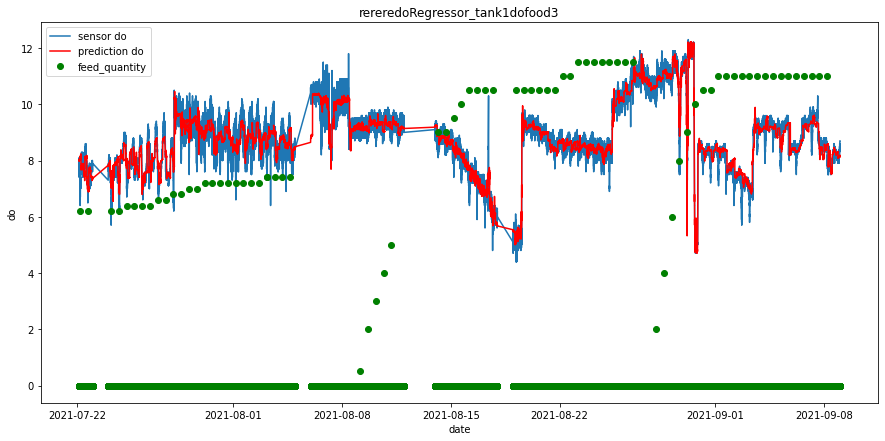

11/11 [==============================] - 1s 10ms/step - loss: 0.1442 - mae: 0.2699 - r_squared: 0.6734


2023-07-10 16:49:15.352196: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100 80GB PCIe MIG 1g.10gb" frequency: 1410 num_cores: 14 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 5242880 shared_memory_size_per_multiprocessor: 167936 memory_size: 8337227776 bandwidth: 241920000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


MSE // MAE // R-squared  [0.1441744565963745, 0.26988816261291504, 0.6734421849250793]


In [37]:
grapeNEva(model, X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [38]:
X_test = japonica_validation_features_X.loc['2021-07-22 00:00':'2021-07-31 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 2))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 71 nVar: 2


In [39]:
y_date = japonica_validation_features_X.loc['2021-07-22 03:00':'2021-07-31 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 12780 nVar: 1
nCar: 71 nVar: 180


12780


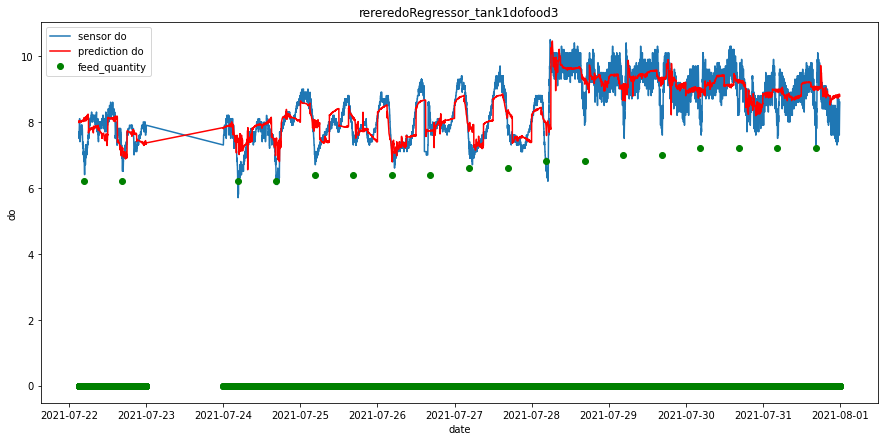

3/3 [==============================] - 0s 10ms/step - loss: 0.2004 - mae: 0.3377 - r_squared: 0.4290
MSE // MAE // R-squared  [0.20039619505405426, 0.33770835399627686, 0.4289608895778656]


In [40]:
grapeNEva(model, X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [41]:
X_test = japonica_validation_features_X.loc['2021-07-22 00:00':'2021-07-22 20:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 2))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 7 nVar: 2


In [42]:
y_date = japonica_validation_features_X.loc['2021-07-22 03:00':'2021-07-22 23:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1260 nVar: 1
nCar: 7 nVar: 180


1260


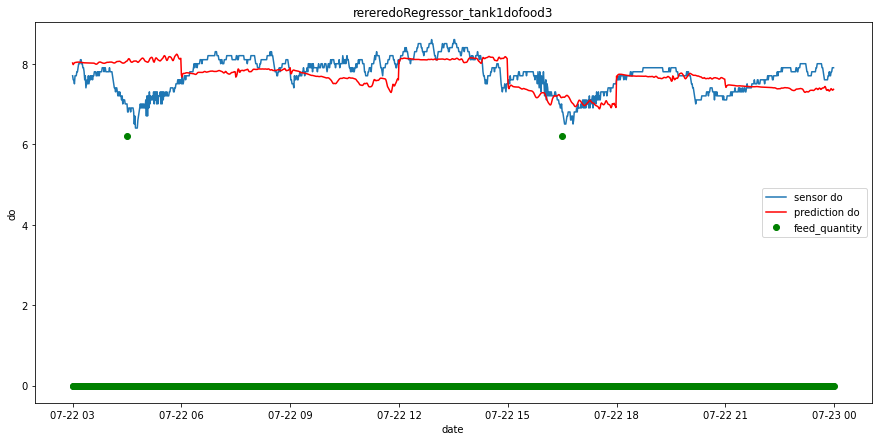

1/1 [==============================] - 0s 50ms/step - loss: 0.1932 - mae: 0.3468 - r_squared: -0.0788
MSE // MAE // R-squared  [0.1931575983762741, 0.34679949283599854, -0.0788412094116211]


In [43]:
grapeNEva(model, X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [44]:
X_test = japonica_validation_features_X.loc['2021-07-22 00:00':'2021-07-22 11:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 2))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 4 nVar: 2


In [45]:
y_date = japonica_validation_features_X.loc['2021-07-22 03:00':'2021-07-22 14:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1
nCar: 4 nVar: 180


720


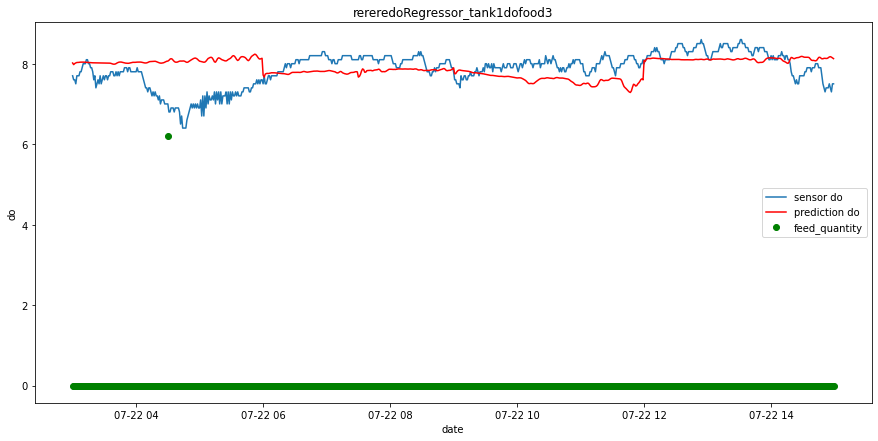

1/1 [==============================] - 0s 41ms/step - loss: 0.2550 - mae: 0.3965 - r_squared: -0.5002
MSE // MAE // R-squared  [0.254950612783432, 0.3964891731739044, -0.5002166032791138]


In [46]:
grapeNEva(model, X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)

In [47]:
japonica_validation_features_X.at['2021-07-22 08:00', 'feed_quantity'] = 6

X_test = japonica_validation_features_X.loc['2021-07-22 00:00':'2021-07-22 11:59']

X_test_reshape = np.asarray(X_test, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 2))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 4 nVar: 2


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [48]:
y_date = japonica_validation_features_X.loc['2021-07-22 03:00':'2021-07-22 14:59']

y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1
nCar: 4 nVar: 180


720


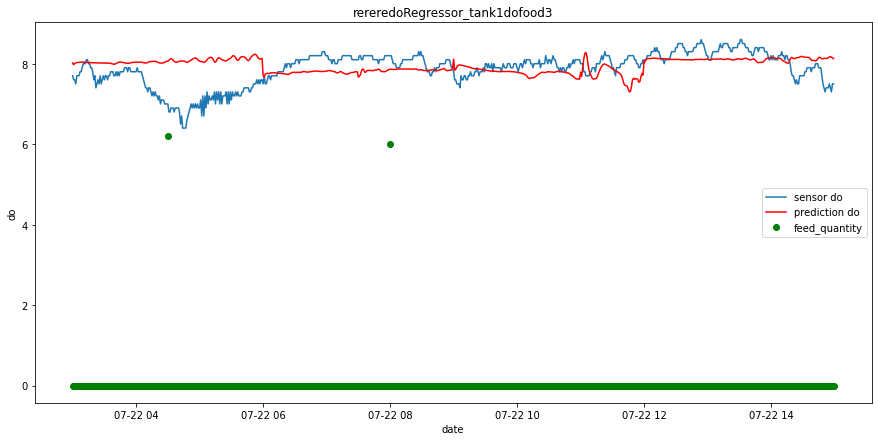

1/1 [==============================] - 0s 117ms/step - loss: 0.2367 - mae: 0.3699 - r_squared: -0.3930
MSE // MAE // R-squared  [0.2367333024740219, 0.3698548674583435, -0.39301979541778564]


In [49]:
grapeNEva(model, X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape)